In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/yuli/anaconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR = '../Uncertainty_Results/'
SHIFT = 'different_author'
TASK = 'CodeSummary_Module'
model = 'code2vec'

src_dir = os.path.join(DIR, SHIFT, model, TASK)
# {train: array, val: array, test1: array, test2: array, test3: array}
label = torch.load(os.path.join(src_dir, 'truth.res')) # Boolean
vanilla = torch.load(os.path.join(src_dir, 'Vanilla.res'))
entropy = torch.load(os.path.join(src_dir, 'Entropy.res')) 
temp = torch.load(os.path.join(src_dir, 'ModelWithTemperature.res'))
dropout = torch.load(os.path.join(src_dir, 'ModelActivateDropout.res'))
mutant = torch.load(os.path.join(src_dir, 'Mutation.res')) # split [array, array, array, array]
dissector = torch.load(os.path.join(src_dir, 'PVScore.res')) # split [array, array, array]

In [256]:
method_transform = {
    'Vanilla': 'Vanilla',
    'Entropy': 'Entropy',
    'ModelWithTemperature': 'Temp Scale',
    'ModelActivateDropout': 'MC-Dropout',
    'Mutation': 'mMutant',
    'PVScore': 'Dissector',
}
task_transform = {
    'CodeSummary_Module': 'Method name prediction',
    'CodeCompletion_Module': 'Code completion',
}
CSMODELS = ['code2vec', 'coderoberta', 'graphcodebert']
CCMODELS = ['lstm', 'codebert', 'codegpt']

def get_dataframe(shift: str, task: str, dir: str = '../Uncertainty_Eval/'):
    record = []
    if task == 'CodeSummary_Module':
        models = CSMODELS
    else:
        models = CCMODELS
    for model in models:
        res = torch.load(os.path.join(dir, shift, model, task, 'uncertainty_eval.res'))
        for ue, outputs in res.items():
            auc_res = outputs['AUC']
            aupr_res = outputs['AUPR']
            brier_res = outputs['Brier']
            if ue in ['Mutation', 'PVScore']:
                auc_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUC',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': auc_res[0]['val']*100,
                    'Shift1': auc_res[0]['test1']*100,
                    'Shift2': auc_res[0]['test2']*100,
                    'Shift3': auc_res[0]['test3']*100,
                }
                aupr_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUPR',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': aupr_res[0]['val']*100,
                    'Shift1': aupr_res[0]['test1']*100,
                    'Shift2': aupr_res[0]['test2']*100,
                    'Shift3': aupr_res[0]['test3']*100,
                }
                brier_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'Brier',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': brier_res[0]['val']*100,
                    'Shift1': brier_res[0]['test1']*100,
                    'Shift2': brier_res[0]['test2']*100,
                    'Shift3': brier_res[0]['test3']*100,
                }
            else:
                auc_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUC',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': auc_res['val']*100,
                    'Shift1': auc_res['test1']*100,
                    'Shift2': auc_res['test2']*100,
                    'Shift3': auc_res['test3']*100,
                }
                aupr_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'AUPR',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': aupr_res['val']*100,
                    'Shift1': aupr_res['test1']*100,
                    'Shift2': aupr_res['test2']*100,
                    'Shift3': aupr_res['test3']*100,
                }
                brier_ins = {
                    'Method': method_transform[ue],
                    'Metric': 'Brier',
                    'Shift': shift,
                    'Task': task_transform[task],
                    'Model': model,
                    'Validation': brier_res['val']*100,
                    'Shift1': brier_res['test1']*100,
                    'Shift2': brier_res['test2']*100,
                    'Shift3': brier_res['test3']*100,
                }
            record.append(auc_ins)
            record.append(aupr_ins)
            record.append(brier_ins)
        
    df = pd.DataFrame(record)
    return df

# Rename the shift intensity names
shift_intensity_names = {
    'Validation': 'In-dist.',
    'Shift1': '1',
    'Shift2': '2',
    'Shift3': '3'
}

### CS misclassification prediction

In [257]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_time'

time_cs_df = get_dataframe(shift, task, dir=dir)
time_cs_brier = time_cs_df[time_cs_df['Metric'] == 'Brier']

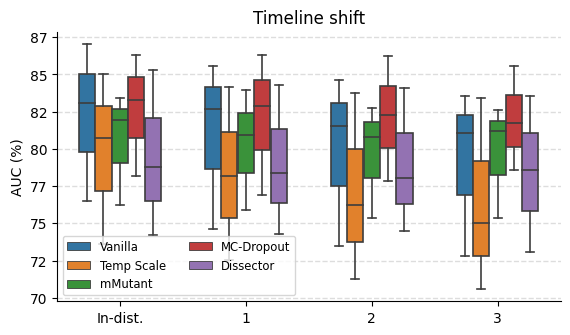

In [492]:
time_cs_auc = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_time'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [73.5909, 79.4082, 76.2293, 76.4762, 83.2745, 74.2274,    85.0456, 84.8456, 83.4005, 87.0435, 86.3323, 85.2777,   80.7000, 77.0327, 81.9378, 83.0686, 78.1921, 78.8093],
    'Shift1':     [72.5611, 74.1318, 75.9097, 74.5896, 82.8990, 74.3168,    84.1747, 80.3423, 83.9688, 85.5941, 86.3301, 84.3000,   78.1556, 72.6137, 80.9110, 82.7000, 76.8935, 78.3678],
    'Shift2':     [71.2602, 72.8542, 75.3423, 73.4817, 82.2513, 74.5058,    83.7821, 80.4276, 82.7655, 84.5976, 86.2355, 84.0884,   76.2295, 72.4456, 80.7969, 81.5427, 77.8357, 78.0476],
    'Shift3':     [70.5871, 72.0741, 75.3601, 72.8127, 81.7309, 73.0786,    83.3923, 81.0733, 82.5825, 83.5333, 85.5618, 83.5439,   75.0127, 71.4967, 81.1697, 81.0550, 78.5781, 78.6105],
})
# Reshape the data using melt function
time_cs_auc_melt = pd.melt(
    time_cs_auc, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
time_cs_auc_melt['Shift_Intensity'] = time_cs_auc_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=time_cs_auc_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('Timeline shift')
plt.xlabel('')
plt.ylabel('AUC (%)')
plt.savefig('../Figure/time_cs_auc.pdf', bbox_inches='tight')
plt.show()

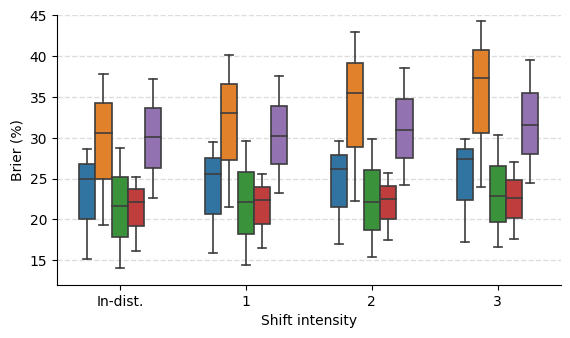

In [422]:
time_cs_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['different_time'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [30.592980, 33.437047, 28.796280, 24.962160, 25.184891, 30.077794,                   
                   19.336671, 30.402568, 14.081326, 15.149775, 16.155470, 22.586598,                   
                   37.849417, 34.008651, 21.631758, 28.571419, 22.169024, 37.176831],
    'Shift1': [32.996684, 21.900038, 29.639067, 25.528006, 25.505021, 30.173111,               
               21.488182, 21.742471, 14.403545, 15.842332, 16.466169, 23.269968,               
               40.162760, 23.243021, 22.071603, 29.457456, 22.361552, 37.600314],
    'Shift2': [35.425975, 31.282420, 29.864350, 26.172010, 25.729080, 30.908954,               
               22.263723, 29.445429, 15.360165, 16.959957, 17.530334, 24.174836,               
               42.982132, 32.520825, 22.139714, 29.562435, 22.530334, 38.516688],
    'Shift3': [37.308647, 34.269486, 30.324157, 27.410457, 27.031744, 31.524608,               
               23.930728, 31.640902, 16.589705, 17.229539, 17.629369, 24.500013,               
               44.283018, 35.527124, 22.856429, 29.850988, 22.629369, 39.548710],
})
# Reshape the data using melt function
time_cs_brier_melt = pd.melt(
    time_cs_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
time_cs_brier_melt['Shift_Intensity'] = time_cs_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=time_cs_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend().remove()
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('Shift intensity')
plt.ylabel('Brier (%)')
plt.ylim(12, 45)
plt.savefig('../Figure/time_cs_brier.pdf', bbox_inches='tight')
plt.show()

In [279]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_project'
project_cs_df = get_dataframe(shift, task)
project_cs_brier = project_cs_df[project_cs_df['Metric'] == 'Brier']

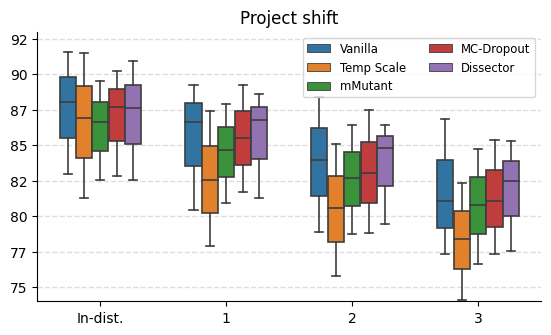

In [493]:
project_cs_auc = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_project'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [81.2892, 85.3722, 82.5648, 82.9977, 82.8536, 82.5188,    86.8978, 88.5987, 89.5117, 88.0474, 90.2631, 90.9689,   91.4884, 88.9076, 86.6064, 91.5600, 87.7090, 87.5938],
    'Shift1':     [77.8627, 82.7522, 80.9355, 80.4149, 81.6695, 81.3008,    82.5598, 77.7263, 87.8978, 86.6201, 89.2601, 88.6126,   87.3997, 83.8937, 84.6484, 89.2702, 85.5348, 86.7621],
    'Shift2':     [75.7582, 80.3515, 78.7409, 78.9116, 78.8401, 79.4517,    80.5980, 78.8665, 86.4451, 83.9887, 87.4989, 86.4601,   85.0793, 84.0066, 82.6597, 88.4281, 83.0254, 84.8238],
    'Shift3':     [74.1181, 78.9998, 76.6045, 77.3065, 77.3322, 77.5220,    78.3853, 77.9501, 84.7071, 81.0400, 85.4043, 85.2681,   82.3378, 78.4503, 80.8207, 86.8490, 81.0739, 82.5028],
})
# Reshape the data using melt function
project_cs_auc_melt = pd.melt(
    project_cs_auc, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
project_cs_auc_melt['Shift_Intensity'] = project_cs_auc_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=project_cs_auc_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('Project shift')
plt.xlabel('')
plt.ylabel('')
plt.ylim(74, 93)
plt.savefig('../Figure/project_cs_auc.pdf', bbox_inches='tight')
plt.show()

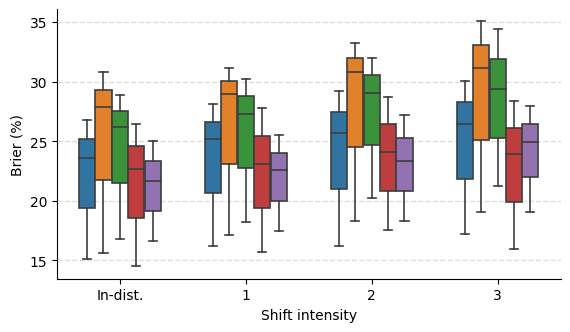

In [421]:
project_cs_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['different_project'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [15.609858, 30.171011, 28.867206, 15.100168, 26.491741, 24.999979, 
                   27.847476, 35.571327, 26.220959, 26.826920, 22.708673, 21.645617, 
                   30.780569, 32.351012, 16.776998, 23.632624, 14.492980, 16.636228],
    'Shift1': [17.167037, 57.117398, 30.226500, 16.176184, 27.773834, 25.552813, 
               28.959579, 61.826044, 27.327685, 28.160773, 23.055151, 22.557965, 
               31.125649, 60.270999, 18.251431, 25.155992, 15.731515, 17.501745],
    'Shift2': [18.308057, 50.156929, 31.962277, 16.228085, 28.744807, 27.243757, 
               30.801999, 57.331127, 29.086278, 29.205767, 24.131077, 23.365518, 
               33.248572, 51.291460, 20.242621, 25.706850, 17.525247, 18.329606],
    'Shift3': [19.053001, 50.976271, 34.396194, 17.248800, 28.374321, 27.934690, 
               31.139891, 58.111439, 29.367401, 30.057668, 23.892808, 24.906326, 
               35.056375, 53.004058, 21.208443, 26.489355, 15.990974, 19.095867],
})
# Reshape the data using melt function
project_cs_brier_melt = pd.melt(
    project_cs_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
project_cs_brier_melt['Shift_Intensity'] = project_cs_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=project_cs_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend().remove()
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('Shift intensity')
plt.ylabel('Brier (%)')
# plt.ylim(12, 45)
plt.savefig('../Figure/project_cs_brier.pdf', bbox_inches='tight')
plt.show()

In [329]:
dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'different_author'

author_cs_df = get_dataframe(shift, task)
author_cs_brier = author_cs_df[author_cs_df['Metric'] == 'Brier']
# author_cs_brier

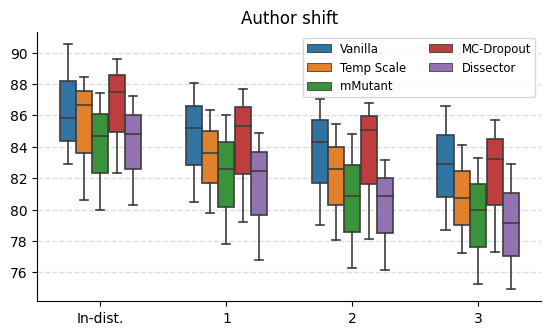

In [494]:
author_cs_auc = pd.DataFrame({
    # 'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Method': ['mMutant', 'Entropy', 'Temp Scale', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_author'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [84.6731, 86.1166, 86.6442, 82.8763, 87.4954, 84.8384,    87.4313, 87.7106, 88.4278, 90.5411, 89.6022, 87.2213,   79.9495, 85.8462, 80.6001, 85.8042, 82.3221, 80.3173],
    'Shift1':     [82.5498, 85.4952, 83.6260, 80.4938, 85.3121, 82.4678,    85.9949, 87.1119, 86.3121, 88.0739, 87.6909, 84.8442,   77.7735, 84.0066, 79.8000, 85.1643, 79.2199, 76.8078],
    'Shift2':     [80.8409, 83.4705, 82.5874, 79.0099, 85.0864, 83.1459,    84.8369, 83.6186, 85.4382, 87.0527, 86.7853, 80.8816,   76.2879, 82.6892, 78.0328, 84.3304, 78.1404, 76.1340],
    'Shift3':     [79.9859, 81.1186, 80.7585, 78.6638, 83.2161, 82.9193,    83.2632, 80.0471, 84.1198, 86.6159, 85.7160, 79.1445,   75.2730, 78.0613, 77.2049, 82.9288, 77.3184, 74.9342],
})
# Reshape the data using melt function
author_cs_auc_melt = pd.melt(
    author_cs_auc, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
author_cs_auc_melt['Shift_Intensity'] = author_cs_auc_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=author_cs_auc_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.title('Author shift')
plt.xlabel('')
plt.ylabel('')
plt.savefig('../Figure/author_cs_auc.pdf', bbox_inches='tight')
plt.show()

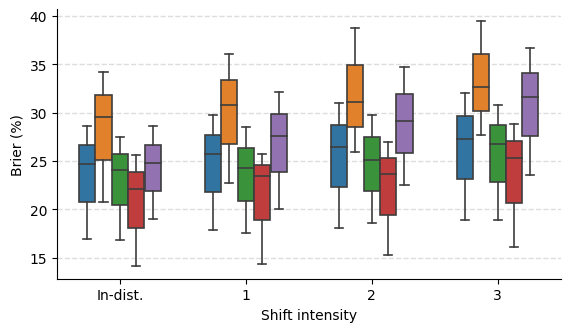

In [420]:
author_cs_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['different_author'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [29.522104, 31.722360, 24.039079, 24.654126, 25.674438, 28.582640, 
                   20.781218, 30.951230, 16.869102, 16.908153, 14.097996, 19.053960, 
                   34.221074, 32.545086, 27.449085, 28.641540, 22.075249, 24.845268],
    'Shift1': [30.783635, 20.718479, 24.236249, 25.702578, 25.770254, 32.180176, 
               22.738814, 20.590217, 17.573614, 17.858014, 14.348630, 20.049371, 
               36.035733, 23.064063, 28.489807, 29.724452, 23.414274, 27.597966],
    'Shift2': [31.078551, 46.104563, 25.145309, 26.498262, 26.952465, 34.746676, 
               25.988194, 45.632564, 18.624869, 18.070123, 15.270705, 22.556107, 
               38.764654, 48.007807, 29.808471, 31.011486, 23.623857, 29.169533],
    'Shift3': [32.661255, 44.514903, 26.758865, 27.316340, 28.881198, 36.689362, 
               27.673847, 43.993512, 18.935581, 18.942913, 16.061410, 23.518849, 
               39.445726, 45.648551, 30.785715, 32.065663, 25.346969, 31.591428],
})
# Reshape the data using melt function
author_cs_brier_melt = pd.melt(
    author_cs_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
author_cs_brier_melt['Shift_Intensity'] = author_cs_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=author_cs_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend().remove()
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('Shift intensity')
plt.ylabel('Brier (%)')
# plt.ylim(12, 45)
plt.savefig('../Figure/author_cs_brier.pdf', bbox_inches='tight')
plt.show()

#### Put all three shifts together

In [530]:
def plot_misclassificaion(
    ax: plt.Axes,
    data_melt: pd.DataFrame,
    x: str = 'Shift_Intensity',
    xlabel: bool = True,
    y: str = 'AUC',
    ylabel: bool = True,
    ylim: tuple = None,
    hue: str = 'Method',
    title: str = None,
    legend: bool = True,
):
    ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
    sns.boxplot(
        data=data_melt, 
        x=x, 
        y=y, 
        hue=hue, 
        hue_order=['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector'], 
        width=0.65,
        linewidth=1.2,
        ax=ax,
    )
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if legend:
        ax.legend(ncols=2, fontsize='small')
    else:
        ax.legend().remove()
    # set the y-axis tick labels as integers
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    if title:
        ax.set_title(title, fontdict={'fontsize': 12})
    else:
        ax.set_title('')
    if xlabel:
        ax.set_xlabel('Shift intensity', fontdict={'fontsize': 12})
    else:
        ax.set_xlabel('')
    if ylabel:
        ax.set_ylabel(f'{y} (%)', fontdict={'fontsize': 12})
    else:
        ax.set_ylabel('')
    if ylim:
        ax.set_ylim(ylim)

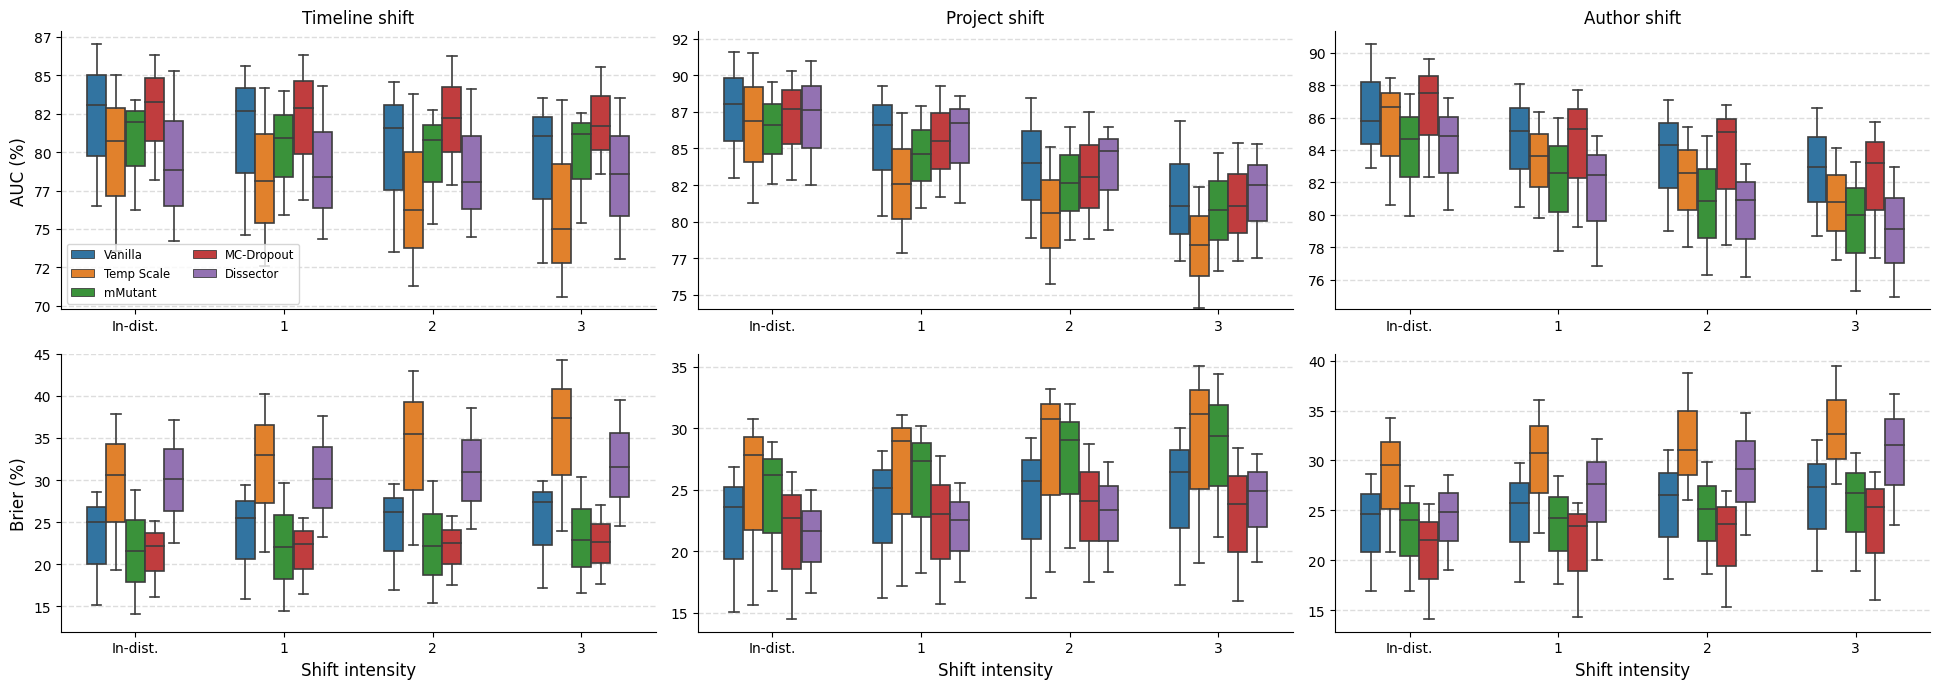

In [531]:
# Create a figure and axis
fig = plt.figure(figsize=(19.5, 7))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

# Plot the data
plot_misclassificaion(
    ax1, 
    data_melt=time_cs_auc_melt, 
    xlabel=False,
    y='AUC',
    ylabel=True,
    title='Timeline shift',
    legend=True,
)

plot_misclassificaion(
    ax2, 
    data_melt=project_cs_auc_melt, 
    xlabel=False,
    y='AUC',
    ylabel=False,
    ylim=(74, 93),
    title='Project shift',
    legend=False,
)

plot_misclassificaion(
    ax3, 
    data_melt=author_cs_auc_melt, 
    xlabel=False,
    y='AUC',
    ylabel=False,
    title='Author shift',
    legend=False,
)

plot_misclassificaion(
    ax4, 
    data_melt=time_cs_brier_melt, 
    xlabel=True,
    y='Brier',
    ylim=(12, 45),
    ylabel=True,
    legend=False,
)

plot_misclassificaion(
    ax5, 
    data_melt=project_cs_brier_melt, 
    xlabel=True,
    y='Brier',
    ylabel=False,
    legend=False,
)

plot_misclassificaion(
    ax6, 
    data_melt=author_cs_brier_melt, 
    xlabel=True,
    y='Brier',
    ylabel=False,
    legend=False,
)

# Remove space between subplots
plt.subplots_adjust(hspace=0.0)
plt.tight_layout()
plt.savefig('../Figure/cs_miscls_detect.pdf', bbox_inches='tight')
plt.show()

### Timeshift CC

In [378]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'different_time'

time_cc_df = get_dataframe(shift, task)
time_cc_brier = time_cc_df[time_cc_df['Metric'] == 'Brier']
# time_cc_brier

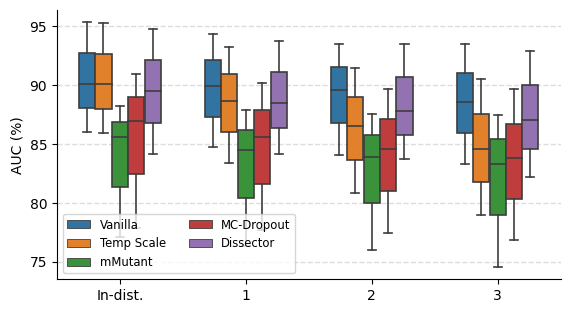

In [495]:
time_cc_auc = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_time'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [90.057371, 94.213335, 85.567362, 90.097439, 77.901314, 89.462009,
                   85.913402, 93.187556, 88.221278, 85.992579, 86.962363, 84.179083,
                   95.264209, 94.599574, 77.077671, 95.355066, 90.980531, 94.766900],
        'Shift1': [88.689983, 94.393282, 84.458234, 89.894074, 77.665605, 88.462009,
                   83.408543, 93.403884, 87.906157, 84.744651, 85.591776, 84.179083,
                   93.251897, 95.118375, 76.336812, 94.331148, 90.212175, 93.766900],
        'Shift2': [86.558287, 92.660309, 83.935840, 89.604016, 77.476437, 87.825101,
                   80.799668, 91.463029, 87.513415, 84.030205, 84.596434, 83.694576,
                   91.425574, 94.028088, 75.957164, 93.448242, 89.642540, 93.520835],
        'Shift3': [84.546747, 92.650167, 83.311443, 88.571927, 76.829043, 87.013218,
                   78.984302, 90.921669, 87.492693, 83.310430, 83.773818, 82.214343,
                   90.497432, 94.020385, 74.550897, 93.516644, 89.674887, 92.931785],
})
# Reshape the data using melt function
time_cc_auc_melt = pd.melt(
    time_cc_auc, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
time_cc_auc_melt['Shift_Intensity'] = time_cc_auc_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=time_cc_auc_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.title('')
plt.xlabel('')
plt.ylabel('AUC (%)')
plt.savefig('../Figure/time_cc_auc.pdf', bbox_inches='tight')
plt.show()

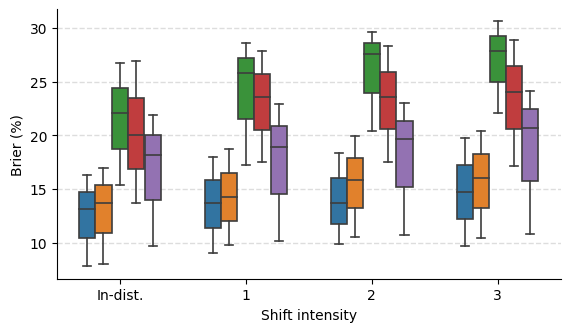

In [419]:
time_cc_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['different_time'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [13.727352, 9.920426, 26.780562, 13.132842, 26.938218, 18.185711, 
                   16.944572, 11.906990, 15.368140, 16.291665, 20.052017, 21.929714, 
                   8.038250, 10.911210, 22.104211, 7.764915, 13.723225, 9.687397],
    'Shift1': [14.268850, 11.434595, 28.576342, 13.688308, 27.898433, 18.896444, 
               18.697830, 13.808163, 17.229878, 17.985221, 23.536769, 22.906352, 
               9.730792, 13.829777, 25.842401, 8.994938, 17.536868, 10.138048],
    'Shift2': [15.838954, 12.099546, 29.632291, 13.713052, 28.312629, 19.695098, 
               19.953931, 15.113315, 20.367574, 18.317296, 23.587750, 23.014914, 
               10.531163, 14.763193, 27.555567, 9.833424, 17.529388, 10.700201],
    'Shift3': [16.058428, 12.408865, 30.621791, 14.731306, 28.872493, 20.723360, 
               20.409088, 15.330907, 22.112933, 19.715057, 24.034234, 24.169714, 
               10.408297, 14.651845, 27.830930, 9.693894, 17.168448, 10.783462],
})
# Reshape the data using melt function
time_cc_brier_melt = pd.melt(
    time_cc_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
time_cc_brier_melt['Shift_Intensity'] = time_cc_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=time_cc_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend().remove()
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('Shift intensity')
plt.ylabel('Brier (%)')
# plt.ylim(12, 45)
plt.savefig('../Figure/time_cc_brier.pdf', bbox_inches='tight')
plt.show()

### Projectshift CC

In [424]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'different_project'

project_cc_df = get_dataframe(shift, task)
project_cc_brier = project_cc_df[project_cc_df['Metric'] == 'Brier']
# project_cc_brier

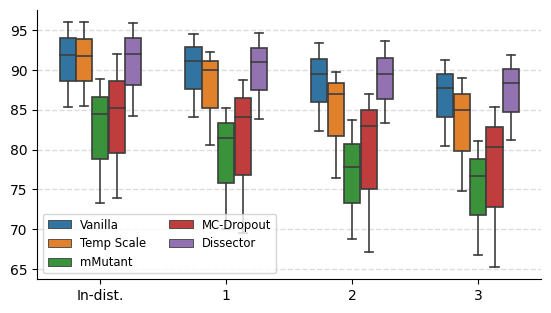

In [496]:
project_cc_auc = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_project'] * 6 + ['different_project'] * 6 + ['different_project'] * 6,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [91.788426, 94.002994, 84.426230, 91.913547, 73.911511, 92.038638,
               85.420518, 93.524027, 88.865109, 85.378159, 85.149608, 84.226601,
               95.998889, 94.113268, 73.323061, 95.988240, 91.977809, 95.883973],
    'Shift1': [89.960156, 85.837561, 81.472428, 91.071379, 69.587164, 90.997980,
               80.528126, 81.954144, 85.232852, 84.041713, 84.116117, 83.864371,
               92.218548, 86.791236, 70.038780, 94.557064, 88.710004, 94.572165],
    'Shift2': [86.994970, 86.574343, 77.775995, 89.511809, 67.167102, 89.458419,
               76.368454, 83.758257, 83.695155, 82.340493, 82.940850, 83.274911,
               89.668135, 86.888459, 68.804132, 93.321035, 86.944238, 93.599955],
    'Shift3': [84.932423, 85.048880, 76.684325, 87.688818, 65.257791, 88.290033,
               74.807386, 79.424085, 81.031253, 80.459384, 80.377717, 81.239069,
               88.952972, 86.008064, 66.774179, 91.203577, 85.280192, 91.904076],
})
# Reshape the data using melt function
project_cc_auc_melt = pd.melt(
    project_cc_auc, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
project_cc_auc_melt['Shift_Intensity'] = project_cc_auc_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=project_cc_auc_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.xlabel('')
plt.ylabel('')
plt.savefig('../Figure/project_cc_auc.pdf', bbox_inches='tight')
plt.show()

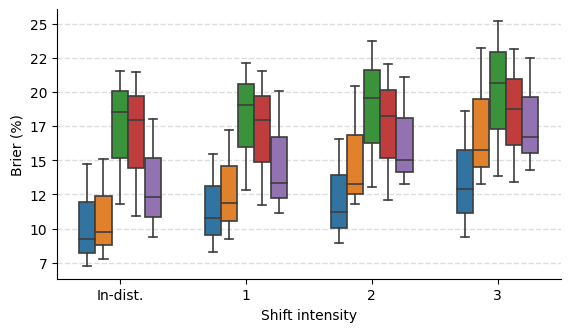

In [462]:
project_cc_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['different_project'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [9.731204, 8.394119, 21.542682, 9.207725, 21.427310, 12.332414, 
                   15.065795, 9.528452, 18.536656, 14.704460, 17.925091, 17.999511, 
                   7.803838, 8.447385, 11.775686, 7.227138, 10.931579, 9.371045],
    'Shift1': [11.899420, 14.534593, 22.146339, 10.805477, 21.503015, 13.303570, 
               17.203979, 19.514014, 19.079684, 15.473735, 17.942474, 20.048823, 
               9.235406, 15.692533, 12.852353, 8.270817, 11.730082, 11.129312],
    'Shift2': [13.239333, 13.645294, 23.710169, 11.221504, 22.057277, 15.035354, 
               20.454885, 18.234655, 19.531059, 16.553420, 18.209816, 21.118538, 
               11.768216, 14.626060, 13.026361, 8.923775, 12.067163, 13.253376],
    'Shift3': [15.757827, 14.986397, 25.155774, 12.862016, 23.124588, 16.733977, 
               23.239990, 21.180052, 20.658747, 18.638749, 18.763878, 22.473571, 
               13.277613, 15.708712, 13.869779, 9.374510, 13.416907, 14.277036],
})
# Reshape the data using melt function
project_cc_brier_melt = pd.melt(
    project_cc_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
project_cc_brier_melt['Shift_Intensity'] = project_cc_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=project_cc_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend().remove()
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('Shift intensity')
plt.ylabel('Brier (%)')
# plt.ylim(12, 45)
plt.savefig('../Figure/project_cc_brier.pdf', bbox_inches='tight')
plt.show()

### Authorshift CC

In [498]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'different_author'

author_cc_df = get_dataframe(shift, task)
author_cc_brier = author_cc_df[author_cc_df['Metric'] == 'Brier']
# author_cc_brier

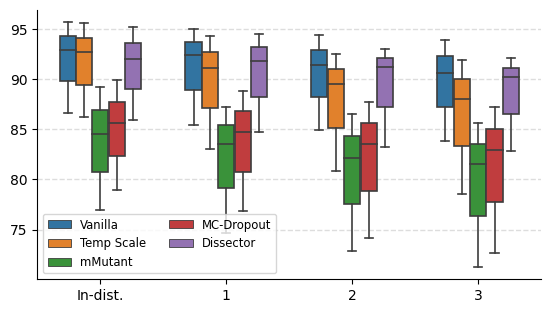

In [497]:
author_cc_auc = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUC'] * 6 * 3,
    'Shift': ['different_author'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [92.710675, 94.157624, 84.583977, 92.947848, 78.999969, 92.033367,               
                   86.240466, 93.795677, 89.205696, 86.646413, 85.638394, 85.976856,               
                   95.650930, 94.044463, 76.922891, 95.734726, 89.946917, 95.207795],
        'Shift1': [91.168989, 94.800748, 83.569791, 92.474183, 76.832330, 91.800408,               
                   83.030028, 94.577983, 87.293861, 85.397773, 84.738986, 84.751669,               
                   94.363243, 94.836510, 74.693025, 95.067125, 88.889671, 94.587477],
        'Shift2': [89.570981, 92.220400, 82.158638, 91.454590, 74.139887, 91.229118,               
                   80.820220, 90.756916, 86.561732, 84.944625, 83.526401, 83.287660,               
                   92.565676, 92.432118, 72.904223, 94.469555, 87.771874, 93.049905],
        'Shift3': [88.092231, 92.639304, 81.499390, 90.669593, 72.640334, 90.221671, 
                   78.522087, 91.848935, 85.639824, 83.880761, 82.919698, 82.848704,
                   91.967359, 93.109261, 71.253575, 93.965705, 87.254396, 92.104877],
})
# Reshape the data using melt function
author_cc_auc_melt = pd.melt(
    author_cc_auc, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='AUC',
)
author_cc_auc_melt['Shift_Intensity'] = author_cc_auc_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=author_cc_auc_melt, 
    x='Shift_Intensity', 
    y='AUC', 
    hue='Method',
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
plt.xlabel('')
plt.ylabel('')
plt.savefig('../Figure/author_cc_auc.pdf', bbox_inches='tight')
plt.show()

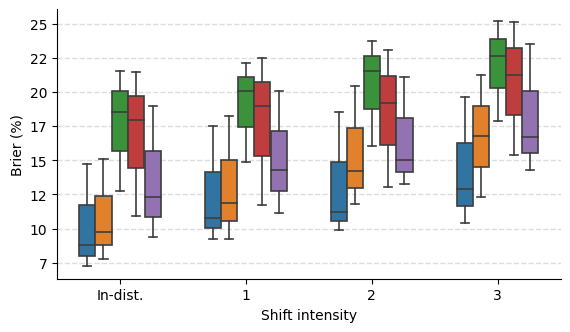

In [505]:
author_cc_brier = df = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['different_project'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [9.731204, 8.394119, 21.542682, 8.807725, 21.427310, 12.332414, 
                   15.065795, 9.528452, 18.536656, 14.704460, 17.925091, 18.999511, 
                   7.803838, 8.447385, 12.775686, 7.227138, 10.931579, 9.371045],
    'Shift1': [11.899420, 14.534593, 22.146339, 10.805477, 22.503015, 14.303570, 
               18.203979, 19.514014, 20.079684, 17.473735, 18.942474, 20.048823, 
               9.235406, 15.692533, 14.852353, 9.270817, 11.730082, 11.129312],
    'Shift2': [14.239333, 13.645294, 23.710169, 11.221504, 23.057277, 15.035354, 
               20.454885, 18.234655, 21.531059, 18.553420, 19.209816, 21.118538, 
               11.768216, 14.626060, 16.026361, 9.923775, 13.067163, 13.253376],
    'Shift3': [16.757827, 14.986397, 25.155774, 12.862016, 25.124588, 16.733977, 
               21.239990, 21.180052, 22.658747, 19.638749, 21.263878, 23.473571, 
               12.277613, 15.708712, 17.869779, 10.374510, 15.416907, 14.277036],
})
# Reshape the data using melt function
author_cc_brier_melt = pd.melt(
    author_cc_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shift1', 'Shift2', 'Shift3'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
author_cc_brier_melt['Shift_Intensity'] = author_cc_brier_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(6.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=author_cc_brier_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend().remove()
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('Shift intensity')
plt.ylabel('Brier (%)')
# plt.ylim(12, 45)
plt.savefig('../Figure/author_cc_brier.pdf', bbox_inches='tight')
plt.show()

#### Put all three shifts together

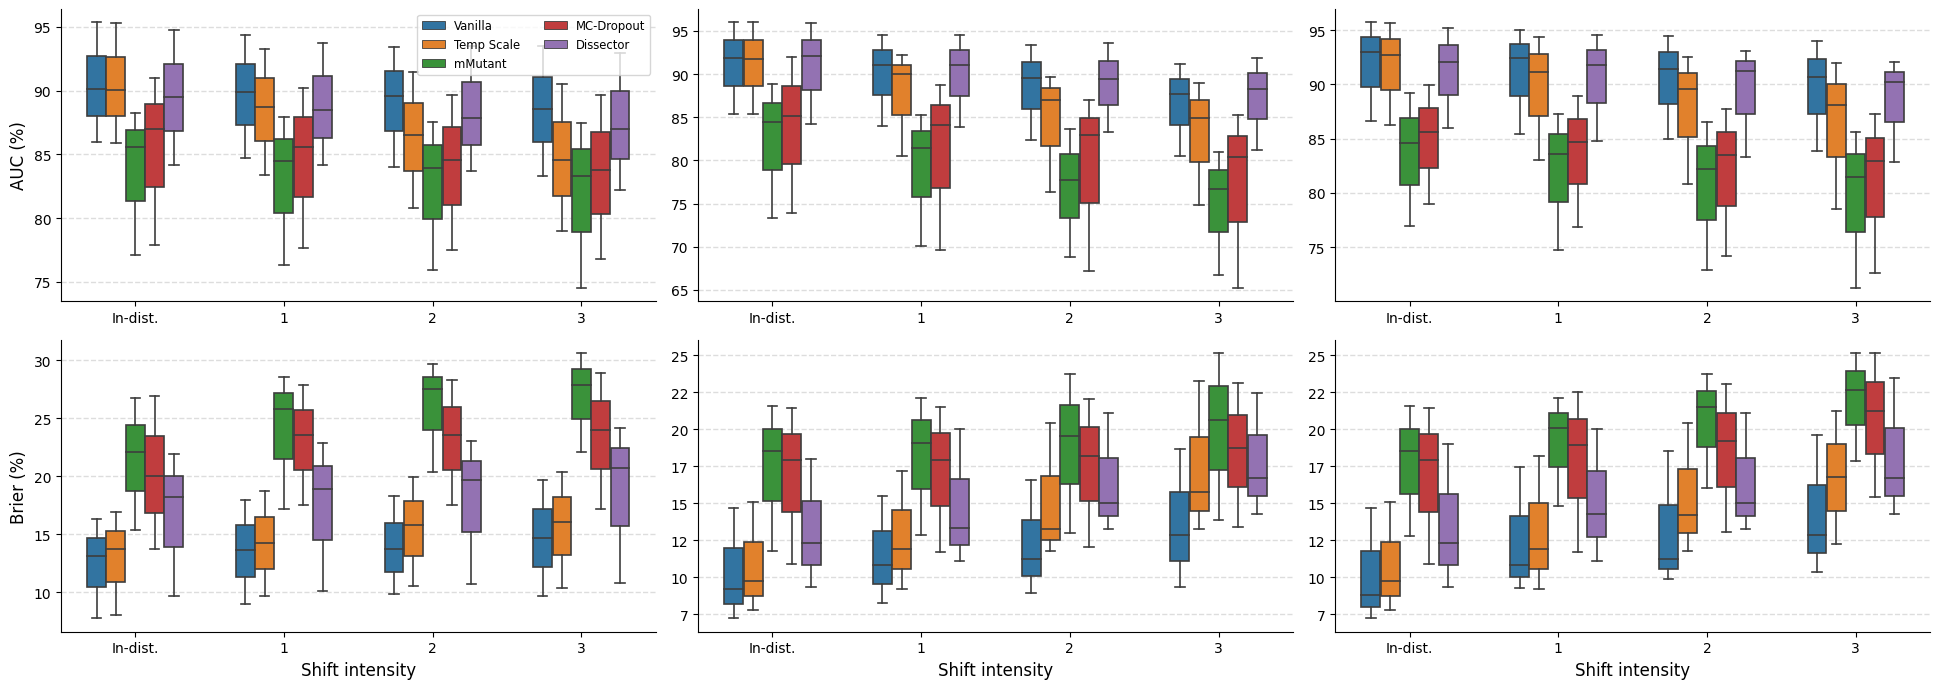

In [532]:
# Create a figure and axis
fig = plt.figure(figsize=(19.5, 7))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

# Plot the data
plot_misclassificaion(
    ax1, 
    data_melt=time_cc_auc_melt, 
    xlabel=False,
    y='AUC',
    ylabel=True,
    # title='Timeline shift',
    legend=True,
)

plot_misclassificaion(
    ax2, 
    data_melt=project_cc_auc_melt, 
    xlabel=False,
    y='AUC',
    ylabel=False,
    # title='Project shift',
    legend=False,
)

plot_misclassificaion(
    ax3, 
    data_melt=author_cc_auc_melt, 
    xlabel=False,
    y='AUC',
    ylabel=False,
    # title='Author shift',
    legend=False,
)

plot_misclassificaion(
    ax4, 
    data_melt=time_cc_brier_melt, 
    xlabel=True,
    y='Brier',
    ylabel=True,
    legend=False,
)

plot_misclassificaion(
    ax5, 
    data_melt=project_cc_brier_melt, 
    xlabel=True,
    y='Brier',
    ylabel=False,
    legend=False,
)

plot_misclassificaion(
    ax6, 
    data_melt=author_cc_brier_melt, 
    xlabel=True,
    y='Brier',
    ylabel=False,
    legend=False,
)

# Remove space between subplots
plt.subplots_adjust(hspace=0.0)
plt.tight_layout()
plt.savefig('../Figure/cc_miscls_detect.pdf', bbox_inches='tight')
plt.show()

## Input validation

In [2]:
DIR = '../Uncertainty_Eval/input_validation'
SHIFT = 'different_time'
METHODS = ['vanilla', 'temperature', 'mutation', 'dropout', 'dissector']
# create dictionary to map original method names to legend names
LEGEND_NAMES = {
    'vanilla': 'Vanilla',
    'temperature': 'Temp Scale',
    'mutation': 'mMutant', 
    'dropout': 'MC-Dropout', 
    'dissector': 'Dissector',
}

In [158]:
def plot_threshold(
    ax: plt.Axes, 
    model1_res: dict, 
    model2_res: dict,
    model3_res: dict,
    x: str = 'threshold',
    x_label: bool = True,
    x_ticklabel: bool = True,
    x_lim: tuple = None,
    x_ticks_gap: float = None,
    y: str = 'F-1',
    y_label: bool = True,
    y_lim: tuple = None,
    y_ticks_gap: float = None,
    legend: bool = True,
    use_val: bool = True,
    use_test1: bool = True,
    use_test2: bool = True,
    use_test3: bool = True,
    gap: int = 1,
    task: str = 'code_completion',
):
    multiplier = 100 if (task == 'code_summary' and y == 'F-1') else 1
    # Loop over each method and plot the shaded area
    for i, method in enumerate(METHODS):
        all_stats = []
        if use_val:
            all_stats.append(np.mean([
                model1_res[method]['val'][y][gap-1::gap],
                model2_res[method]['val'][y][gap-1::gap],
                model3_res[method]['val'][y][gap-1::gap],
            ], axis=0) * multiplier)
        if use_test1:
            all_stats.append(np.mean([
                model1_res[method]['test1'][y][gap-1::gap],
                model2_res[method]['test1'][y][gap-1::gap],
                model3_res[method]['test1'][y][gap-1::gap],
            ], axis=0) * multiplier)
        if use_test2:
            all_stats.append(np.mean([
                model1_res[method]['test2'][y][gap-1::gap],
                model2_res[method]['test2'][y][gap-1::gap],
                model3_res[method]['test2'][y][gap-1::gap],
            ], axis=0) * multiplier)
        if use_test3:
            all_stats.append(np.mean([
                model1_res[method]['test3'][y][gap-1::gap],
                model2_res[method]['test3'][y][gap-1::gap],
                model3_res[method]['test3'][y][gap-1::gap],
            ], axis=0) * multiplier)
        mean_acc = np.mean(all_stats, axis=0)
        std_acc = np.std(all_stats, axis=0)
        if y == 'threshold' or y == 'coverage':
            ax.plot(model1_res[x][gap-1::gap], mean_acc, label=LEGEND_NAMES[method])
            ax.fill_between(model1_res[x][gap-1::gap], mean_acc-std_acc, mean_acc+std_acc, alpha=0.1)
        else:
            ax.plot(1-model1_res[x][gap-1::gap], mean_acc, label=LEGEND_NAMES[method])
            ax.fill_between(1-model1_res[x][gap-1::gap], mean_acc-std_acc, mean_acc+std_acc, alpha=0.1)

    # Add labels, title, and legend
    ax.set_xlabel(r'Threshold $\tau$')
    if y == 'threshold' or y == 'coverage':
        ax.set_ylabel(r'Number of examples $U(x) \geq \tau$')
        ax.set_ylim(0, 1)
    elif y == 'F-1':
        ax.set_ylabel(r'F-1 (%) of examples $U(x) \geq \tau$')
    else:
        ax.set_ylabel(f'{y} (%)')
    if x_lim is not None:
        ax.set_xlim(x_lim)
    else:
        ax.set_xlim(0, 1)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    if legend:
        ax.legend(fontsize='small')
    else:
        ax.legend().remove()
    if not x_ticklabel:
        ax.set_xticklabels([])
    if not x_label:
        ax.set_xlabel('')
    if not y_label:
        ax.set_ylabel('')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
    if x_ticks_gap is not None:
        ax.xaxis.set_major_locator(plt.MultipleLocator(x_ticks_gap))
    if y_ticks_gap is not None:
        ax.yaxis.set_major_locator(plt.MultipleLocator(y_ticks_gap))
    # ax.tick_params(axis='x', rotation=45)

In [159]:
def case_study_threshold(
    ax: plt.Axes, 
    model1_res: dict, 
    model2_res: dict,
    model3_res: dict,
    x: str = 'threshold',
    x_label: bool = True,
    x_ticklabel: bool = True,
    x_lim: tuple = None,
    x_ticks_gap: float = None,
    y: str = 'F-1',
    y_label: bool = True,
    y_lim: tuple = None,
    y_ticks_gap: float = None,
    legend: bool = True,
    use_val: bool = True,
    use_test: bool = True,
    gap: int = 1,
    task: str = 'code_completion',
):
    multiplier = 100 if (task == 'code_summary' and y == 'F-1') else 1
    # Loop over each method and plot the shaded area
    for i, method in enumerate(METHODS):
        all_stats = []
        if use_val:
            all_stats.append(np.mean([
                model1_res[method]['val'][y][gap-1::gap],
                model2_res[method]['val'][y][gap-1::gap],
                model3_res[method]['val'][y][gap-1::gap],
            ], axis=0) * multiplier)
        if use_test:
            all_stats.append(np.mean([
                model1_res[method]['test'][y][gap-1::gap],
                model2_res[method]['test'][y][gap-1::gap],
                model3_res[method]['test'][y][gap-1::gap],
            ], axis=0) * multiplier)
        mean_acc = np.mean(all_stats, axis=0)
        std_acc = np.std(all_stats, axis=0)
        if y == 'threshold' or y == 'coverage':
            ax.plot(model1_res[x][gap-1::gap], mean_acc, label=LEGEND_NAMES[method])
            ax.fill_between(model1_res[x][gap-1::gap], mean_acc-std_acc, mean_acc+std_acc, alpha=0.1)
        else:
            ax.plot(1-model1_res[x][gap-1::gap], mean_acc, label=LEGEND_NAMES[method])
            ax.fill_between(1-model1_res[x][gap-1::gap], mean_acc-std_acc, mean_acc+std_acc, alpha=0.1)

    # Add labels, title, and legend
    ax.set_xlabel(r'Threshold $\tau$')
    if y == 'threshold' or y == 'coverage':
        ax.set_ylabel(r'Number of examples $U(x) \geq \tau$')
        ax.set_ylim(0, 1)
    elif y == 'F-1':
        ax.set_ylabel(r'F-1 (%) of examples $U(x) \geq \tau$')
    else:
        ax.set_ylabel(f'{y} (%)')
    if x_lim is not None:
        ax.set_xlim(x_lim)
    else:
        ax.set_xlim(0, 1)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    if legend:
        ax.legend(fontsize='small')
    else:
        ax.legend().remove()
    if not x_ticklabel:
        ax.set_xticklabels([])
    if not x_label:
        ax.set_xlabel('')
    if not y_label:
        ax.set_ylabel('')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
    if x_ticks_gap is not None:
        ax.xaxis.set_major_locator(plt.MultipleLocator(x_ticks_gap))
    if y_ticks_gap is not None:
        ax.yaxis.set_major_locator(plt.MultipleLocator(y_ticks_gap))
    # ax.tick_params(axis='x', rotation=45)

### CS input validation

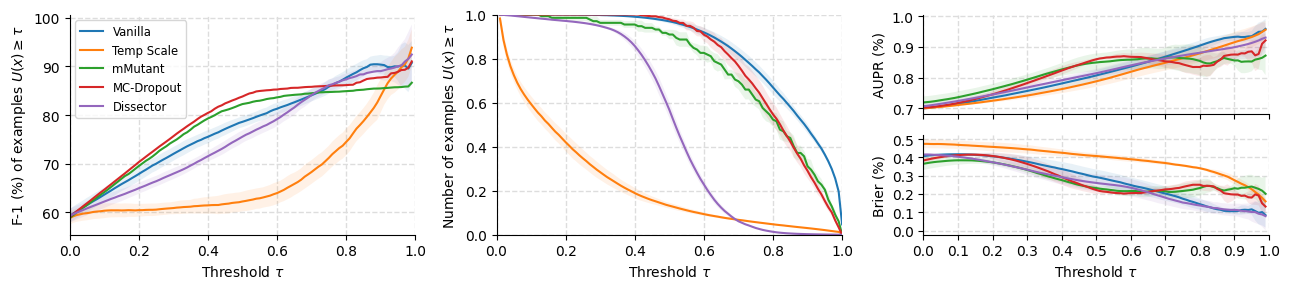

In [170]:
TASK = 'CodeSummary_Module'
SHIFT = 'different_time'
code2vec_res = torch.load(os.path.join(DIR, SHIFT, 'code2vec', TASK, 'filter_coverage.res'))
coderoberta_res = torch.load(os.path.join(DIR, SHIFT, 'coderoberta', TASK, 'filter_coverage.res'))
graphcodebert_res = torch.load(os.path.join(DIR, SHIFT, 'graphcodebert', TASK, 'filter_coverage.res'))
models_res = [code2vec_res, coderoberta_res, graphcodebert_res]

# Preprocess mutation (F-1), dropout (F-1), and temperature (threshold) results
for split in ['val', 'test1', 'test2', 'test3']:
    for model_res in models_res:
        model_res['mutation'][split]['F-1'] = sorted(model_res['mutation']['val']['F-1'], reverse=True)
        model_res['dropout'][split]['F-1'] = sorted(model_res['dropout']['val']['F-1'], reverse=True)
        model_res['temperature'][split]['threshold'] = np.array(model_res['temperature'][split]['threshold']) * 1.65
    for method in METHODS:
        for model_res in models_res:
            aupr_scores = model_res[method][split]['AUPR']
            model_res[method][split]['AUPR'] = (aupr_scores - min(aupr_scores)) * (max(aupr_scores) - 0.7) / (max(aupr_scores) - min(aupr_scores)) + 0.7
            brier_scores = model_res[method][split]['Brier']
            model_res[method][split]['Brier'] = (brier_scores - min(brier_scores)) * (0.42 - min(brier_scores)) / (max(brier_scores) - min(brier_scores)) + min(brier_scores)

# Create a figure and axis
fig = plt.figure(figsize=(13, 3))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3_top = fig.add_subplot(gs[0, 2])
ax3_bottom = fig.add_subplot(gs[1, 2])

plot_threshold(
    ax=ax1, 
    model1_res=code2vec_res, 
    model2_res=coderoberta_res, 
    model3_res=graphcodebert_res, 
    use_test1=False,
    x='coverage',
    y='F-1',
    legend=True,
    gap=1,
    task='code_summary',
)
plot_threshold(
    ax=ax2, 
    model1_res=code2vec_res, 
    model2_res=coderoberta_res, 
    model3_res=graphcodebert_res, 
    x='coverage',
    y='threshold',
    legend=False,
    task='code_summary',
)
plot_threshold(
    ax=ax3_top, 
    model1_res=code2vec_res, 
    model2_res=coderoberta_res, 
    model3_res=graphcodebert_res, 
    x='coverage',
    x_label=False,
    x_ticklabel=False,
    x_ticks_gap=0.1,
    y='AUPR',
    y_ticks_gap=0.1,
    legend=False,
    task='code_summary',
)
plot_threshold(
    ax=ax3_bottom, 
    model1_res=code2vec_res, 
    model2_res=coderoberta_res, 
    model3_res=graphcodebert_res, 
    x='coverage',
    x_ticks_gap=0.1,
    y='Brier',
    y_ticks_gap=0.1,
    legend=False,
    task='code_summary',
)

# Remove space between subplots
plt.subplots_adjust(hspace=0.0)
# plot on ax1, ax2, ax3_top, and ax3_bottom as desired
plt.tight_layout()
plt.savefig("../Figure/filter_cs.pdf", bbox_inches='tight')
plt.show()

### CC input validation

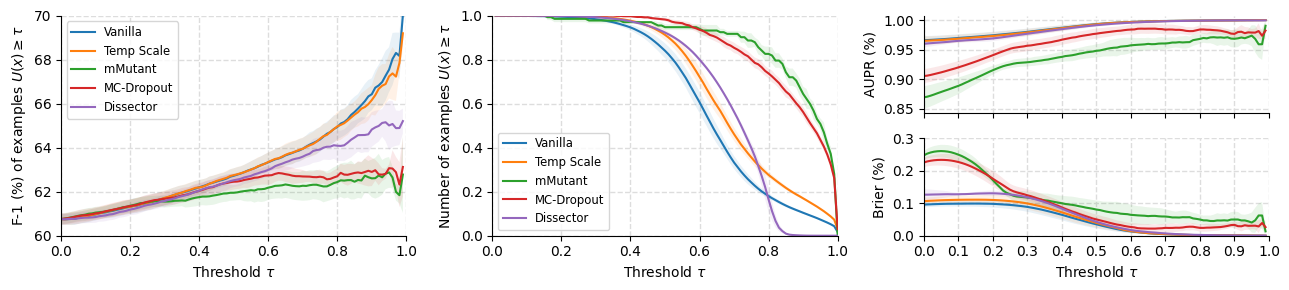

In [169]:
TASK = 'CodeCompletion_Module'
SHIFT = 'different_time'
lstm_coverage_res = torch.load(os.path.join(DIR, SHIFT, 'lstm', TASK, 'filter_coverage.res'))
codebert_coverage_res = torch.load(os.path.join(DIR, SHIFT, 'codebert', TASK, 'filter_coverage.res'))
codegpt_coverage_res = torch.load(os.path.join(DIR, SHIFT, 'codegpt', TASK, 'filter_coverage.res'))
models_res = [lstm_coverage_res, codebert_coverage_res, codegpt_coverage_res]

# Preprocess AUPR and Brier results
for split in ['val', 'test1', 'test2', 'test3']:
    for method in METHODS:
        for model_res in models_res:
            aupr_scores = model_res[method][split]['AUPR']
            model_res[method][split]['AUPR'] = (aupr_scores - min(aupr_scores)) * (1 - min(aupr_scores)) / (max(aupr_scores) - min(aupr_scores)) + min(aupr_scores)
            brier_scores = model_res[method][split]['Brier']
            model_res[method][split]['Brier'] = (brier_scores - min(brier_scores)) * (max(brier_scores) - 0) / (max(brier_scores) - min(brier_scores))

# Create a figure and axis
fig = plt.figure(figsize=(13, 3))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3_top = fig.add_subplot(gs[0, 2])
ax3_bottom = fig.add_subplot(gs[1, 2])

plot_threshold(
    ax=ax1, 
    model1_res=lstm_coverage_res, 
    model2_res=codebert_coverage_res, 
    model3_res=codegpt_coverage_res, 
    x='coverage',
    use_val=False,
    y='F-1',
    y_lim=(60, 70),
    legend=True,
)
plot_threshold(
    ax=ax2, 
    model1_res=lstm_coverage_res, 
    model2_res=codebert_coverage_res, 
    model3_res=codegpt_coverage_res, 
    x='coverage',
    y='threshold',
    legend=True,
)
plot_threshold(
    ax=ax3_top, 
    model1_res=lstm_coverage_res, 
    model2_res=codebert_coverage_res, 
    model3_res=codegpt_coverage_res, 
    x='coverage',
    x_label=False,
    x_ticks_gap=0.1,
    x_ticklabel=False,
    y='AUPR',
    y_ticks_gap=0.05,
    legend=False,
)
plot_threshold(
    ax=ax3_bottom, 
    model1_res=lstm_coverage_res, 
    model2_res=codebert_coverage_res, 
    model3_res=codegpt_coverage_res, 
    x='coverage',
    x_ticks_gap=0.1,
    y='Brier',
    y_lim=(0, 0.3),
    y_ticks_gap=0.1,
    legend=False,
)

# Remove space between subplots
plt.subplots_adjust(hspace=0.0)
# plot on ax1, ax2, ax3_top, and ax3_bottom as desired
plt.tight_layout()
plt.savefig("../Figure/filter_cc.pdf", bbox_inches='tight')
plt.show()

### Case study input validation

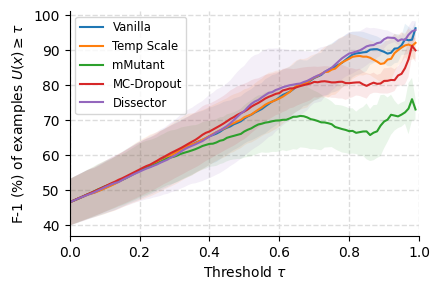

In [148]:
TASK = 'CodeSummary_Module'
SHIFT = 'case_study'
code2vec_res = torch.load(os.path.join(DIR, SHIFT, 'code2vec', TASK, 'filter_coverage.res'))
coderoberta_res = torch.load(os.path.join(DIR, SHIFT, 'coderoberta', TASK, 'filter_coverage.res'))
graphcodebert_res = torch.load(os.path.join(DIR, SHIFT, 'graphcodebert', TASK, 'filter_coverage.res'))
models_res = [code2vec_res, coderoberta_res, graphcodebert_res]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4.5, 3))
case_study_threshold(
    ax=ax, 
    model1_res=code2vec_res, 
    model2_res=coderoberta_res, 
    model3_res=graphcodebert_res, 
    x='coverage',
    y='F-1',
    legend=True,
    gap=1,
    task='code_summary',
)

# Remove space between subplots
plt.subplots_adjust(hspace=0.0)
# plot on ax1, ax2, ax3_top, and ax3_bottom as desired
plt.tight_layout()
plt.savefig("../Figure/filter_cs_study.pdf", bbox_inches='tight')
plt.show()

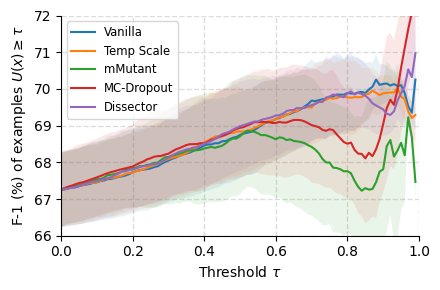

In [150]:
TASK = 'CodeCompletion_Module'
SHIFT = 'case_study'
lstm_res = torch.load(os.path.join(DIR, SHIFT, 'lstm', TASK, 'filter_coverage.res'))
codebert_res = torch.load(os.path.join(DIR, SHIFT, 'codebert', TASK, 'filter_coverage.res'))
codegpt_res = torch.load(os.path.join(DIR, SHIFT, 'codegpt', TASK, 'filter_coverage.res'))
models_res = [lstm_res, codebert_res, codegpt_res]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4.5, 3))
case_study_threshold(
    ax=ax, 
    model1_res=lstm_res, 
    model2_res=codebert_res, 
    model3_res=codegpt_res, 
    x='coverage',
    y='F-1',
    y_lim=(66, 72),
    legend=True,
    gap=1,
    task='code_completion',
)

# Remove space between subplots
plt.subplots_adjust(hspace=0.0)
# plot on ax1, ax2, ax3_top, and ax3_bottom as desired
plt.tight_layout()
plt.savefig("../Figure/filter_cc_study.pdf", bbox_inches='tight')
plt.show()

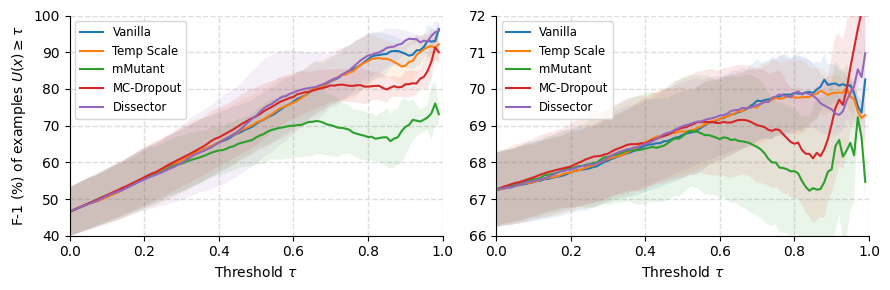

In [144]:
# Put cs and cc results together
# Create a figure and axis
fig = plt.figure(figsize=(9, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

case_study_threshold(
    ax=ax1, 
    model1_res=code2vec_res, 
    model2_res=coderoberta_res, 
    model3_res=graphcodebert_res, 
    x='coverage',
    y='F-1',
    y_lim=(40, 100),
    legend=True,
    gap=1,
    task='code_summary',
)

case_study_threshold(
    ax=ax2, 
    model1_res=lstm_res, 
    model2_res=codebert_res, 
    model3_res=codegpt_res, 
    x='coverage',
    y='F-1',
    y_label=False,
    y_lim=(66, 72),
    legend=True,
    gap=1,
    task='code_completion',
)

# Remove space between subplots
plt.subplots_adjust(hspace=0.0)
# plot on ax1, ax2, ax3_top, and ax3_bottom as desired
plt.tight_layout()
plt.savefig("../Figure/filter_study.pdf", bbox_inches='tight')
plt.show()